In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
data_input = pd.read_excel("Data.xlsx")
orig_data = data_input.drop(columns=["Раздел", "Коллекция", "Trademark", "No"])
orig_data.columns = ["Temperature[C]", "Dose[dpa]", "Swelling[pc]"]
orig_data.head(5)

,Temperature[C],Dose[dpa],Swelling[pc]
0,540.0,50.9558,18.533333
1,650.0,46.0000,1.934760
2,650.0,70.5000,8.802582
3,650.0,83.0000,20.557254
4,600.0,43.5000,4.048115


In [39]:
def analytical_solution_base(T, D, dose_rate=1e-6):
    """
    atr: 
    k: irradiation dose rate
    T: irradiation temperature
    D: irradiation dose
    """
    phi = lambda x: x * (np.sign(x) + 1) / 2
    
    T_max = 690 + 15.5 * np.log(dose_rate) # peak swelling temperature
    sigma_T = 12.3 - 1.9* np.log(dose_rate) # temperature dispersion of distribution 
    dTh = sigma_T * 2 * (2 * np.log(2)) ** .5 # FWHM temperature distribution 
    R = 0.25 - 0.022 * np.log(dose_rate) # peak swelling rate at T = T_max 
    D_inc = 103 - 0.1 * T + 2.6 * np.log(dose_rate)
    # D_inc = 640 + 2.6 * np.log(dose_rate) - 1.17 * T
    swelling = R * phi(D - D_inc) * np.exp(- (T - T_max) ** 2 / 2 / sigma_T ** 2)
    return swelling



## Dose dependences

In [183]:
def get_box(temperature):
    sample = rounded_data[rounded_data["Temperature[C]"] == temperature]
    doses = sample["Dose[dpa]"].unique()
    swelling_values = []
    for dose in doses:
        swelling_values.append(np.array(sample[sample["Dose[dpa]"] == dose]["Swelling[pc]"]))
    return swelling_values, doses


def get_sample(size=5):
    temperature_list = np.array(sample_size[sample_size > size].index)
    print(temperature_list)
    n = len(temperature_list)
    n_row = (n - 1) //3 + 1
    fig, axes = plt.subplots(n_row, 3, figsize=(15, 3 * n_row), layout="constrained")
    for i, temperature in enumerate(temperature_list):
        sample = rounded_data[rounded_data["Temperature[C]"] == temperature]
        axes.flat[i].scatter(sample["Dose[dpa]"], sample["Swelling[pc]"])
        dose_range = np.linspace(sample["Dose[dpa]"].min(), sample["Dose[dpa]"].max() + 5, 100)
        axes.flat[i].plot(dose_range, analytical_solution(temperature, dose_range))
        axes.flat[i].set(title=f"Temp={temperature}", ylabel="Swelling[percent]", xlabel="Dose[dpa]")
        
        
def get_boxplots(size=20, analytical_solution=analytical_solution_base, white_list=None, scd=None):
    sample_size = rounded_data.groupby("Temperature[C]").describe()["Dose[dpa]"]["count"]
    temperature_list = np.array(sample_size[sample_size > size].index) if white_list is None else white_list
    print(temperature_list)
    n = len(temperature_list)
    n_cols = 2 if n != 1 else 1
    n_row = (n - 1) // n_cols + 1
    fig, axes = plt.subplots(n_row, n_cols, figsize=(20, (10 // n_cols) * n_row), layout="constrained")
    for i, temperature in enumerate(temperature_list):
        swelling_values, doses = get_box(temperature)
        mean_swellings = []
        for swelling_value in swelling_values:
            mean_swellings.append(np.mean(swelling_value))
        ax = axes.flat[i] if n != 1 else axes
        
        dose_range = np.linspace(doses.min(), doses.max(), 100)
        widths = (dose_range[-1] - dose_range[0]) / 30
        ax.boxplot(swelling_values, positions=doses, widths=widths)
        for i, dose in enumerate(doses):
            ax.scatter([dose]*len(swelling_values[i]), swelling_values[i], s=5, c="red")
        ax.scatter(doses, mean_swellings, c="blue", label="average experiment")
        errors = abs(analytical_solution(temperature, doses, dose_rate=1e-6) - np.array(mean_swellings))
        # print(analytical_solution(temperature, dose_range))
        ax.plot(dose_range, analytical_solution(temperature, dose_range, dose_rate=1e-6), ls=":", label="dose_rate=1e-6")
        # ax.plot(dose_range, analytical_solution(temperature, dose_range, dose_rate=1e-4), ls=":", label="dose_rate=1e-4")
        # ax.plot(dose_range, analytical_solution(temperature, dose_range, dose_rate=1e-3), ls="-", label="dose_rate=1e-3")
        # ax.plot(dose_range, analytical_solution(temperature, dose_range, dose_rate=1e-2), ls=":", label="dose_rate=1e-2")
        ax.set(title=f"Temp={temperature}[C]", ylabel="Swelling[percent]", xlabel="Dose[dpa]")
        print(np.mean(errors))
        ax.legend()
        
        if scd is not None:
            ax.plot(scd[temperature][0], scd[temperature][1])

## Temperature dependences

In [149]:
def get_box_dose(dose):
    sample = rounded_data[rounded_data["Dose[dpa]"] == dose]
    temperatures = sample["Temperature[C]"].unique()
    swelling_values = []
    for temperature in temperatures:
        swelling_values.append(np.array(sample[sample["Temperature[C]"] == temperature]["Swelling[pc]"]))
    return swelling_values, temperatures
        
        
def get_boxplots_dose(size=20, analytical_solution=analytical_solution_base, white_list=None, scd=None):
    sample_size = rounded_data.groupby("Dose[dpa]").describe()["Temperature[C]"]["count"]
    doses = np.array(sample_size[sample_size > size].index) if white_list is None else white_list
    print(doses)
    n = len(doses)
    n_cols = 2 if n != 1 else 1
    n_row = (n - 1) // n_cols + 1
    fig, axes = plt.subplots(n_row, n_cols, figsize=(20, (10 // n_cols) * n_row), layout="constrained")
    for i, dose in enumerate(doses):

        swelling_values, temperatures = get_box_dose(dose)
        mean_swellings = []
        for swelling_value in swelling_values:
            mean_swellings.append(np.mean(swelling_value))
        ax = axes.flat[i] if n != 1 else axes
        
        temperature_range = np.linspace(temperatures.min() - 10, temperatures.max() + 10, 100)
        widths = (temperature_range[-1] - temperature_range[0]) / 30
        ax.boxplot(swelling_values, positions=temperatures, widths=widths)
        for i, temp in enumerate(temperatures):
            ax.scatter([temp]*len(swelling_values[i]), swelling_values[i], s=5, c="red")
        ax.scatter(temperatures, mean_swellings, c="blue", label="average experiment")
        errors = abs(analytical_solution(temperatures, dose, dose_rate=1e-6) - np.array(mean_swellings))
        # print(temperatures)
        # print(analytical_solution(temperatures, dose, dose_rate=1e-6))
        # print(np.array(mean_swellings))
        # print("errors", errors)
        print(np.mean(errors))
        ax.plot(temperature_range, analytical_solution(temperature_range, dose, dose_rate=1e-6), ls=":", label="dose_rate=1e-6")
        # ax.plot(temperature_range, analytical_solution(temperature_range, dose, dose_rate=1e-4), ls=":", label="dose_rate=1e-4")
        # ax.plot(temperature_range, analytical_solution(temperature_range, dose, dose_rate=1e-3), ls="-", label="dose_rate=1e-3")
        # ax.plot(temperature_range, analytical_solution(temperature_range, dose, dose_rate=1e-2), ls=":", label="dose_rate=1e-2")
        ax.set(title=f"Dose={dose}[dpa]", ylabel="Swelling[percent]", xlabel="Temperature[C]")
        ax.legend()
        
        if scd is not None:
            ax.plot(scd[dose][0], scd[dose][1])

## Calculations

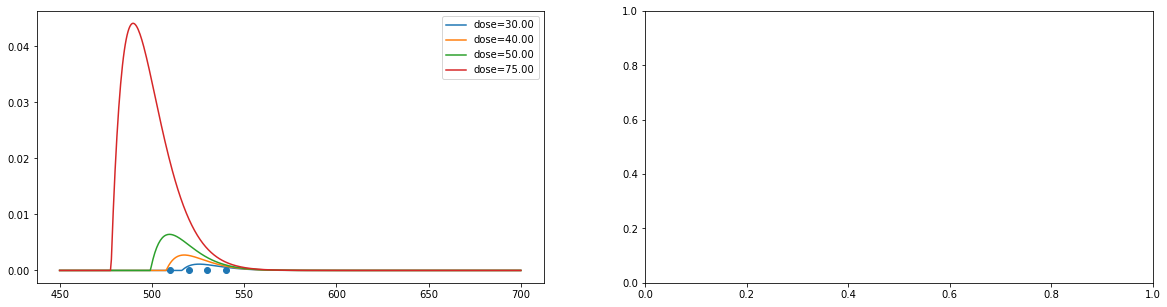

In [57]:
def analytical_solution_verb(T, D, k=1e-6, log=False):
    """
    atr: 
    k: irradiation dose rate
    T: irradiation temperature
    D: irradiation dose
    """
    phi = lambda x: x * (np.sign(x) + 1) / 2
    
    T_max = 580 + 15.5 * np.log(k) # peak swelling temperature
    sigma_T = 12.3 - 1.9* np.log(k) # temperature dispersion of distribution
    dTh = sigma_T * 2 * (2 * np.log(2)) ** .5 # FWHM temperature distribution
    R = 0.25 - 0.022 * np.log(k) # peak swelling rate at T = T_max
    # D_inc = 103 - 0.1 * T + 2.6 * np.log(k)
    D_inc = 670 + 2.6 * np.log(k) - 1.17*T
    # D_inc = 5 * T - 2000
    
    

    swelling = 1 * R * phi(D - D_inc) * np.exp(- (T - T_max) ** 2 / 2 / sigma_T ** 2)
    if log:
        print(f"{T_max=:10.2f}\n{sigma_T=:2.2f}\n{dTh=:2.2f}\n{R=:2.2f}\n{D_inc=:2.2f}\n{swelling=:2.2f}\n")
    return swelling


fig, axes = plt.subplots(1, 2, figsize=(20, 5))
doses = np.array([30, 40, 50,    75])
maxes = np.array([540, 530, 520,    510])
temperatures = np.linspace(450, 700, 500)
for dose in doses:
    axes[0].plot(temperatures, analytical_solution_verb(temperatures, dose), label=f"{dose=:2.2f}")
axes[0].scatter(maxes, 0*doses/10)
    # axes[0].plot(temperatures, 10*temperatures - 5300)
axes[0].legend();

In [132]:
def analytical_solution_mod(T, D, dose_rate=1e-6):
    """
    atr: 
    k: irradiation dose rate
    T: irradiation temperature
    D: irradiation dose
    """
    phi = lambda x: x * (np.sign(x) + 1) / 2
    
    T_max = 710 + 15.5 * np.log(dose_rate) # peak swelling temperature
    sigma_T = 12.3 - 1.9* np.log(dose_rate) # temperature dispersion of distribution 
    dTh = sigma_T * 2 * (2 * np.log(2)) ** .5 # FWHM temperature distribution 
    R = 0.25 - 0.022 * np.log(dose_rate) # peak swelling rate at T = T_max 
    D_inc = 103 - 0.1 * T + 2.6 * np.log(dose_rate)
    # D_inc = 640 + 2.6 * np.log(dose_rate) - 1.17 * T
    swelling = R * phi(D - D_inc) * np.exp(- (T - T_max) ** 2 / 2 / sigma_T ** 2)
    return swelling



[40, 50, 70, 75]
2.4334670888296177
2.3511146484967
6.778466380892536
4.667275557857042


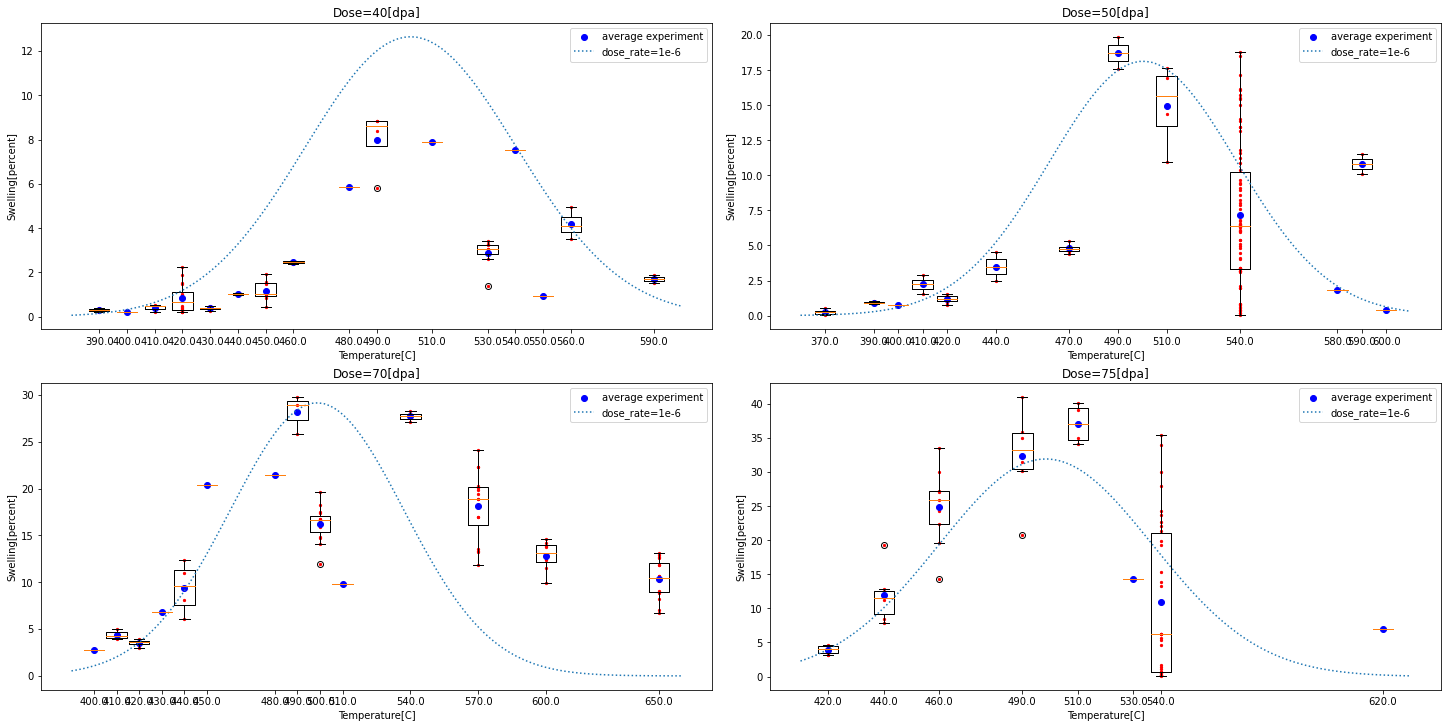

In [150]:
rounded_data = orig_data
rounded_data["Temperature[C]"] = orig_data["Temperature[C]"].round(-1)
rounded_data["Dose[dpa]"] = orig_data["Dose[dpa]"].round()
a = orig_data["Dose[dpa]"]
rounded_data["Dose[dpa]"] = (a - a % 5) * (a % 5 < 3) + (a + -a % 5) * (a % 5 > 2)
get_boxplots_dose(40, analytical_solution_mod, [40, 50, 70, 75])

[420, 540]
0.41008211544473405
8.93553712217865


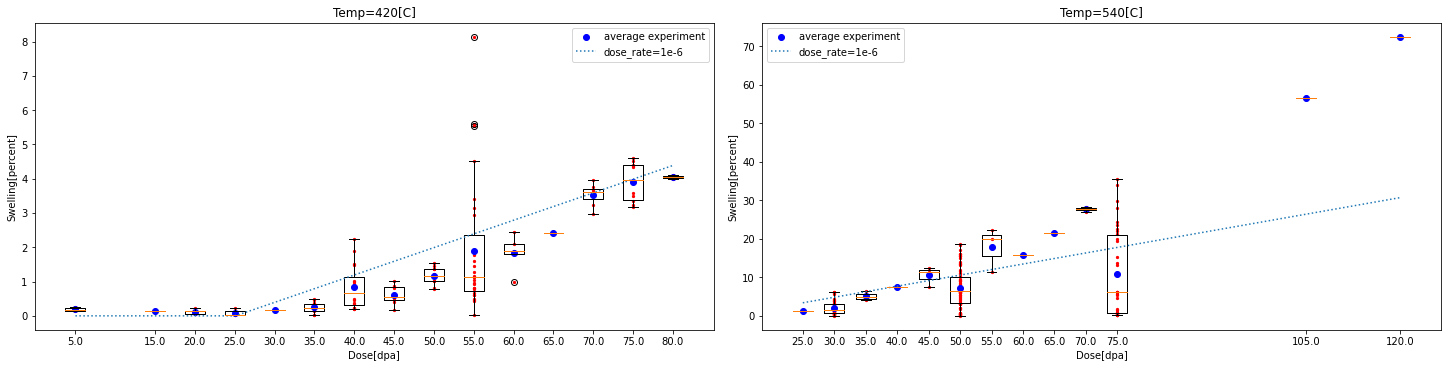

In [136]:
rounded_data["Temperature[C]"] = orig_data["Temperature[C]"].round(-1)
rounded_data["Dose[dpa]"] = orig_data["Dose[dpa]"].round()
get_boxplots(30, analytical_solution_mod, [420, 540])

In [ ]:
ebr2, superphenix
conc Ti
CW  
40
50
70
75

420
500
540
570
650


[40, 50, 70, 75]
2.4334670888296177
2.3511146484967
6.778466380892536
4.667275557857042


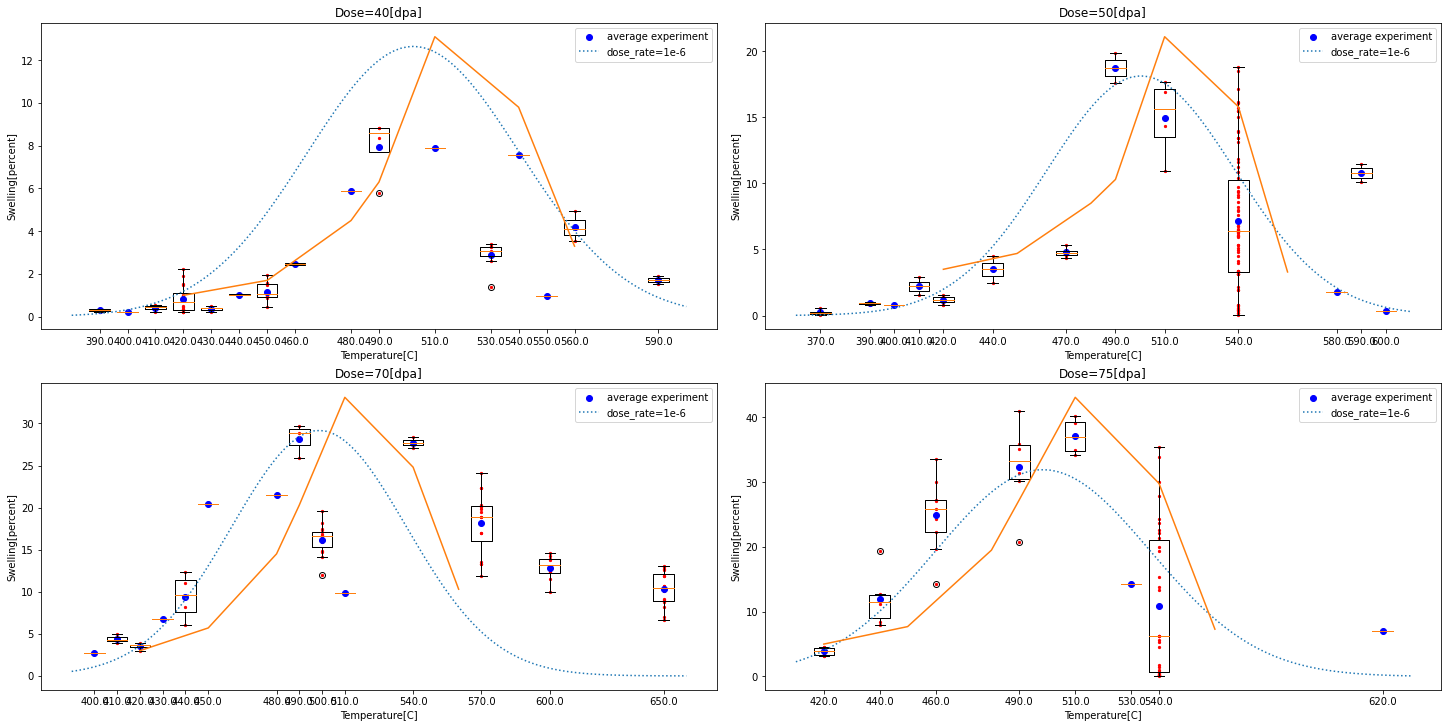

In [184]:
rounded_data = orig_data
rounded_data["Temperature[C]"] = orig_data["Temperature[C]"].round(-1)
rounded_data["Dose[dpa]"] = orig_data["Dose[dpa]"].round()
a = orig_data["Dose[dpa]"]
rounded_data["Dose[dpa]"] = (a - a % 5) * (a % 5 < 3) + (a + -a % 5) * (a % 5 > 2)
scd_temp = {40: [[420, 450, 480, 490, 510, 540, 560], [1, 1.7, 4.5, 6.3, 13.1, 9.8, 3.3]],
            50: [[420, 450, 480, 490, 510, 540, 560], [3.5, 4.7, 8.5, 10.3, 21.1, 15.8, 3.3]],
            70: [[420, 450, 480, 490, 510, 540, 560], [3, 5.7, 14.5, 20.3, 33.1, 24.8, 10.3]],
            75: [[420, 450, 480, 490, 510, 540, 560], [5, 7.7, 19.5, 27.3, 43.1, 29.8, 7.3]],
           }
get_boxplots_dose(40, analytical_solution_mod, [40, 50, 70, 75], scd=scd_temp)

[420, 540]
0.41008211544473405
8.93553712217865


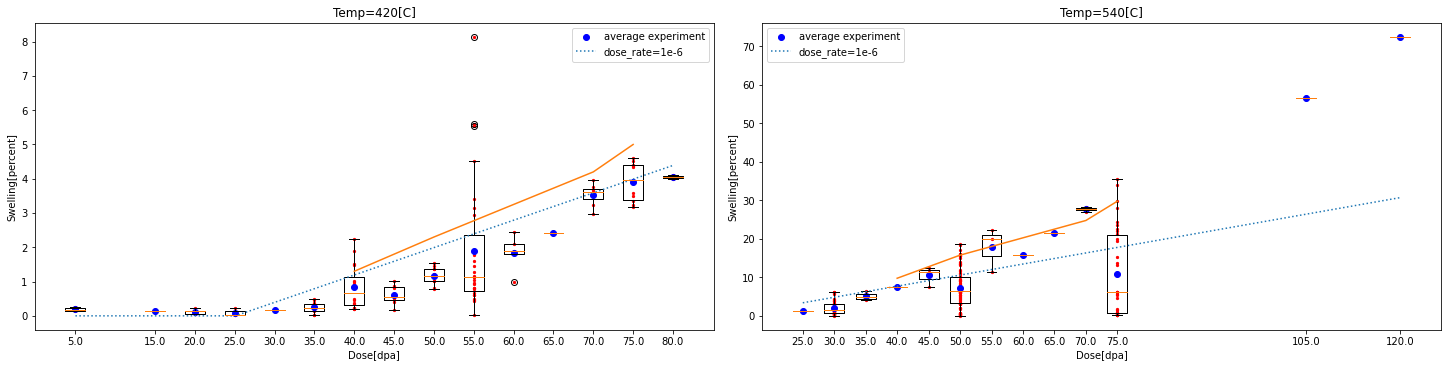

In [194]:
rounded_data["Temperature[C]"] = orig_data["Temperature[C]"].round(-1)
rounded_data["Dose[dpa]"] = orig_data["Dose[dpa]"].round()
scd_dose = {420: [[40, 50, 70, 75], [1.3, 2.3, 4.2, 5]],
            540: [[40, 50, 70, 75], [9.8, 15.8, 24.8, 29.8]],
           }
get_boxplots(30, analytical_solution_mod, [420, 540], scd=scd_dose)